In [165]:
import json
import re
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections.abc import Mapping, Sequence
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Variáveis

In [166]:
DIR_PATTERN = re.compile(
    r"^fedavg_random_(?P<strategy>constant|aff|hetaaff|criticalfl|dynff)_battery_False_"
    r"dataset_cifar10_dir_(?P<alpha>0\.1|1\.0)_seed_(?P<seed>1|2|3|4|5)$"
)

MILLIJOULES_PER_J = 1000.0
BYTES_PER_MB = 1e6  # use 1024**2 para MiB
PARTICIPANTS_ORDER = [10]
ALPHA_ORDER = [0.1, 1.0]
ROOT_CONSTANT = Path("/home/filipe/Workspace/dynff/results/new/exp-1/shufflenet/constant").expanduser().resolve()
ROOT_CRITICAL = Path("/home/filipe/Workspace/dynff/results/new/exp-1/shufflenet/critical").expanduser().resolve()
ROOT_AFF = Path("/home/filipe/Workspace/dynff/results/new/exp-1/shufflenet/aff").expanduser().resolve()
ROOT_HETAAFF = Path("/home/filipe/Workspace/dynff/results/new/exp-1/shufflenet/hetaaff").expanduser().resolve()
ROOT_DYNFF_DYN = Path("/home/filipe/Workspace/dynff/results/new/exp-1/shufflenet/dynff/ack-3").expanduser().resolve()
ROOT_DYNFF_FIX = Path("/home/filipe/Workspace/dynff/results/new/exp-1/shufflenet/dynff/fixed").expanduser().resolve()

OUTPUT = Path("/home/filipe/Workspace/dynff/experiments/motivational/figs").expanduser().resolve()
OUTPUT.mkdir(parents=True, exist_ok=True)

# Função Auxiliar

In [167]:
def read_json(path: Path):
    try:
        with path.open("r", encoding="utf-8") as f:
            return json.load(f)
    except Exception as e:
        print(f"[WARN] Falha ao ler {path}: {e}")
        return None


def parse_round_key_to_idx(k: str) -> int:
    # chaves deslocadas em +1: "1" -> rodada 0
    try:
        return int(k) - 1
    except Exception:
        return None


def stacked_differences(totals_by_participants):
    """
    Recebe dict {participants -> total}, retorna lista de segmentos empilhados
    correspondentes às diferenças cumulativas (crescentes com PARTICIPANTS_ORDER).
    Ex.: [total_5, total_10-total_5, total_20-total_10]
    """
    segs = []
    prev = 0.0
    for p in PARTICIPANTS_ORDER:
        cur = totals_by_participants.get(p, 0.0)
        segs.append(max(cur - prev, 0.0))
        prev = cur
    return segs


# ---------- Pipeline ----------
def collect_runs(root: Path, strategy: str = None):
    """
    Varre o root e retorna lista de runs com campos:
    (participants:int, alpha:float, seed:int, model_perf:dict, system_perf:dict)
    """
    runs = []
    for child in root.iterdir():
        if not child.is_dir():
            continue
        
        m = DIR_PATTERN.match(child.name)
        
        if not m:
            print(f"[WARN] Falha ao ler {child}: {m}")
            continue
        
        if strategy == None:
            strategy = str(m.group("strategy"))
        alpha = float(m.group("alpha"))
        seed = int(m.group("seed"))
        
        mp = read_json(child / "model_performance.json")
        sp = read_json(child / "system_performance.json")
        
        if mp is None or sp is None:
            print(f"[WARN] Ignorando {child} por falta de arquivos válidos.")
            continue

        runs.append((strategy, alpha, seed, mp, sp))
    
    return runs


def aggregate_accuracy_by_round(runs):
    """
    Retorna DataFrame com média por rodada de cen_accuracy para cada (participants, alpha).
    index: round, columns: MultiIndex (metric: 'cen_accuracy', participants, alpha)
    Também retorna um DF "long" com colunas: round, participants, alpha, cen_accuracy
    """
    acc_records = []
    for strategy, alpha, seed, mp, _ in runs:
        for rk, vals in mp.items():
            ridx = parse_round_key_to_idx(rk)
            if ridx is None or ridx < 0:
                continue
            acc = vals.get("cen_accuracy", None)
            if acc is None:
                continue
            acc_records.append({
                "round": ridx,
                "strategy": strategy,
                "alpha": alpha,
                "seed": seed,
                "cen_accuracy": acc
            })

    df = pd.DataFrame(acc_records)
    if df.empty:
        return pd.DataFrame(), pd.DataFrame()

    # média por rodada entre seeds
    df_mean = (
        df.groupby(["round", "strategy", "alpha"])["cen_accuracy"]
        .mean()
        .reset_index()
    )

    # Pivot para facilitar plot grade (linhas=participants, colunas=alpha)
    # Mantemos DF "long" para flexibilidade
    return df_mean, df  # (médias por rodada), (cru)

def aggregate_system_totals(runs):
    """
    Para cada (strategy, alpha, seed), soma por rodada e faz média entre seeds do:
      - total_mJ  -> convertido para Joules (total_J)
      - selected_mJ -> convertido para Joules (selected_J)
      - num_transmited_bytes -> convertido para MB (total_MB)
      - selected_ceq  -> soma por rodada (selected_ceq)
      - num_participants -> média por rodada (mean_participants)

    Retorna (na ordem):
      totals_energy[alpha][strategy]     = total_J (média entre seeds)
      selected_energy[alpha][strategy]   = selected_J (média entre seeds)
      totals_bytes[alpha][strategy]      = total_MB (média entre seeds)
      selected_ceq_dict[alpha][strategy] = selected_ceq (média entre seeds)
      num_participants_dict[alpha][strategy] = mean_participants (média entre seeds)

      dfe, dfb, dfc, dfp                # DataFrames por run (energia/bytes/ceq/participants)
      dfe_total_mean, dfe_selected_mean, dfb_mean, dfc_mean, dfp_mean   # agregados por α/strategy

      # NOVOS:
      dfp_round                          # participantes por run e por rodada (alpha, strategy, seed, round_idx)
      dfp_round_mean                     # média por (alpha, strategy, round_idx) agregando seeds
      num_participants_by_round          # dict: [alpha][strategy][round_idx] -> média entre seeds
    """
    energy_records = []      # por run (total/selected J)
    bytes_records = []       # por run (MB)
    ceq_records = []         # por run (selected_ceq)
    participants_records = []          # por run (média por rodada)
    participants_round_records = []    # por run-rodada

    for strategy, alpha, seed, _, sp in runs:
        total_mJ = 0.0
        selected_mJ = 0.0
        total_bytes = 0.0
        selected_ceq = 0.0

        part_sum = 0.0
        round_count_for_part = 0

        for rk, vals in sp.items():
            ridx = parse_round_key_to_idx(rk)
            if ridx is None or ridx < 0:
                continue

            total_mJ += float(vals.get("total_mJ", 0.0))
            selected_mJ += float(vals.get("selected_mJ", 0.0))
            total_bytes += float(vals.get("num_transmited_bytes", 0.0))
            selected_ceq += float(vals.get("selected_ceq", 0.0))

            # coleta por rodada
            if "num_participants" in vals:
                npart = float(vals.get("num_participants", 0.0))
                part_sum += npart
                round_count_for_part += 1
                participants_round_records.append({
                    "strategy": strategy,
                    "alpha": alpha,
                    "seed": seed,
                    "round_idx": int(ridx),
                    "num_participants": npart
                })

        mean_participants = (
            part_sum / round_count_for_part if round_count_for_part > 0 else np.nan
        )

        energy_records.append({
            "strategy": strategy,
            "alpha": alpha,
            "seed": seed,
            "total_J": total_mJ / MILLIJOULES_PER_J,
            "selected_J": selected_mJ / MILLIJOULES_PER_J
        })
        bytes_records.append({
            "strategy": strategy,
            "alpha": alpha,
            "seed": seed,
            "total_MB": total_bytes / BYTES_PER_MB
        })
        ceq_records.append({
            "strategy": strategy,
            "alpha": alpha,
            "seed": seed,
            "selected_ceq": selected_ceq
        })
        participants_records.append({
            "strategy": strategy,
            "alpha": alpha,
            "seed": seed,
            "mean_participants": mean_participants
        })

    # DataFrames por run
    dfe = pd.DataFrame(energy_records)
    dfb = pd.DataFrame(bytes_records)
    dfc = pd.DataFrame(ceq_records)
    dfp = pd.DataFrame(participants_records)
    dfp_round = pd.DataFrame(participants_round_records)

    # Médias entre seeds por (alpha, strategy)
    dfe_total_mean = (
        dfe.groupby(["alpha", "strategy"])["total_J"].mean().reset_index()
    )
    dfe_selected_mean = (
        dfe.groupby(["alpha", "strategy"])["selected_J"].mean().reset_index()
    )
    dfb_mean = (
        dfb.groupby(["alpha", "strategy"])["total_MB"].mean().reset_index()
    )
    dfc_mean = (
        dfc.groupby(["alpha", "strategy"])["selected_ceq"].mean().reset_index()
    )
    dfp_mean = (
        dfp.groupby(["alpha", "strategy"])["mean_participants"].mean().reset_index()
    )

    # NOVO: média por rodada (agregando seeds)
    if not dfp_round.empty:
        dfp_round_mean = (
            dfp_round
            .groupby(["alpha", "strategy", "round_idx"])["num_participants"]
            .mean()
            .reset_index()
        )
    else:
        dfp_round_mean = pd.DataFrame(columns=["alpha", "strategy", "round_idx", "num_participants"])

    # Dicts por alpha -> strategy -> valor
    totals_energy = defaultdict(dict)
    selected_energy = defaultdict(dict)
    totals_bytes = defaultdict(dict)
    selected_ceq_dict = defaultdict(dict)
    num_participants_dict = defaultdict(dict)
    # NOVO: por rodada
    num_participants_by_round = defaultdict(lambda: defaultdict(dict))  # [alpha][strategy][round_idx]

    for _, row in dfe_total_mean.iterrows():
        totals_energy[row["alpha"]][row["strategy"]] = float(row["total_J"])
    for _, row in dfe_selected_mean.iterrows():
        selected_energy[row["alpha"]][row["strategy"]] = float(row["selected_J"])
    for _, row in dfb_mean.iterrows():
        totals_bytes[row["alpha"]][row["strategy"]] = float(row["total_MB"])
    for _, row in dfc_mean.iterrows():
        selected_ceq_dict[row["alpha"]][row["strategy"]] = float(row["selected_ceq"])
    for _, row in dfp_mean.iterrows():
        num_participants_dict[row["alpha"]][row["strategy"]] = float(row["mean_participants"])

    # preencher dict por rodada
    for _, row in dfp_round_mean.iterrows():
        a = row["alpha"]
        s = row["strategy"]
        r = int(row["round_idx"])
        num_participants_by_round[a][s][r] = float(row["num_participants"])

    return (
        totals_energy,
        selected_energy,
        totals_bytes,
        selected_ceq_dict,
        num_participants_dict,
        dfe, dfb, dfc, dfp,
        dfe_total_mean, dfe_selected_mean, dfb_mean, dfc_mean, dfp_mean,
        # novos retornos ao final:
        dfp_round,
        dfp_round_mean,
        num_participants_by_round,
    )

def _flatten_strategy_dict(d):
    """Converte {alpha: {'estrategia': valor_mJ}} -> {alpha: valor_mJ}."""
    flat = {}
    for alpha, v in d.items():
        if isinstance(v, dict) and v:
            flat[float(alpha)] = float(next(iter(v.values())))
        else:
            flat[float(alpha)] = float(v)
    return flat

def plot_energy_grouped_with_labels(strategy_dicts, x_order=(0.1, 1.0),
                                    title='Selected Clients Energy by Strategy vs. α'):
    # Achatar e garantir floats
    flat = {name: _flatten_strategy_dict(d) for name, d in strategy_dicts.items()}

    xs = list(x_order)
    n = len(xs)
    strategies = list(flat.keys())
    k = len(strategies)
    idx = np.arange(n)
    width = 0.8 / max(k, 1)

    # Valores em MJ
    vals_by_strategy = {
        name: [flat[name].get(x, np.nan) / 1e6 for x in xs] for name in strategies
    }

    # Máximo p/ folga vertical
    all_vals = np.array([v for vals in vals_by_strategy.values() for v in vals], dtype=float)
    ymax = np.nanmax(all_vals) if np.isfinite(np.nanmax(all_vals)) else 1.0

    fig, ax = plt.subplots(figsize=(9, 5))

    bars_by_strategy = {}
    for i, name in enumerate(strategies):
        vals_mj = vals_by_strategy[name]
        bars = ax.bar(idx + (i - (k - 1)/2) * width, vals_mj, width, label=name)
        bars_by_strategy[name] = bars

        # rótulos em MJ no topo das barras (Matplotlib >= 3.4)
        labels = [f"{v:.2f} MJ" if np.isfinite(v) else "" for v in vals_mj]
        if hasattr(ax, "bar_label"):
            ax.bar_label(bars, labels=labels, padding=3, fontsize=9)  # pode exigir ajuste de ylim
        else:
            for rect, lab in zip(bars, labels):
                if not lab:
                    continue
                h = rect.get_height()
                ax.text(rect.get_x() + rect.get_width()/2, h, lab,
                        ha="center", va="bottom", fontsize=9)

    # --- NOVO: percentual vs. constant abaixo da barra ---
    const_vals = vals_by_strategy.get('constant', [np.nan] * n)
    # quão “abaixo” das barras colocar o texto (fração do ymax):
    pct_offset = 0.04
    for name, bars in bars_by_strategy.items():
        if name == 'constant':
            continue  # não rotular a referência
        vals_mj = vals_by_strategy[name]
        for j, rect in enumerate(bars):
            val = vals_mj[j]
            cval = const_vals[j]
            if not (np.isfinite(val) and np.isfinite(cval) and cval != 0):
                continue
            pct = (val - cval) / cval * 100.0
            sign = "+" if pct >= 0 else "−"
            pct_text = f"{sign}{abs(pct):.1f}%"
            x = rect.get_x() + rect.get_width()/2
            y = -pct_offset * ymax  # um pouco abaixo de 0
            ax.text(x, y, pct_text, ha="center", va="top", fontsize=9)

    ax.set_xticks(idx)
    ax.set_xticklabels([str(x) for x in xs])
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel('Energy (MJ)')
    ax.set_title(title)
    ax.legend(title='Strategy')
    ax.grid(axis='y', linestyle=':', alpha=0.5)

    # dá folga em cima (rótulos MJ) e embaixo (percentuais)
    upper_pad = 1.12
    lower_pad = 0.10  # ajuste se quiser mais/menos espaço abaixo
    ax.set_ylim(-ymax * lower_pad, ymax * upper_pad)

    fig.tight_layout()
    plt.show()


# ---------- Utils ----------
def _normalize_strategy_label(s: str) -> str:
    if not isinstance(s, str):
        return s
    m = {
        "constant": "Constant",
        "critical": "Critical",
        "criticalfl": "Critical",   # ajuste opcional
        "aff": "Aff",
        "hetaaff": "Hetaaff",
    }
    return m.get(s.strip().lower(), s.strip().title())

def _ensure_strategy(df: pd.DataFrame, fallback: str | None) -> pd.DataFrame:
    out = df.copy()
    if "strategy" not in out.columns or out["strategy"].isna().any():
        if fallback is None:
            raise ValueError("Faltou a coluna 'strategy' e não há fallback para rotular.")
        out["strategy"] = fallback
    out["strategy"] = out["strategy"].map(_normalize_strategy_label)
    required = {"round", "alpha", "cen_accuracy", "strategy"}
    missing = required - set(out.columns)
    if missing:
        raise ValueError(f"Colunas faltando no DataFrame: {sorted(missing)}")
    return out

def _gather_by_prefix(prefix="df_acc_rounds_mean_", namespace=None) -> list[pd.DataFrame]:
    ns = namespace if namespace is not None else globals()
    frames = []
    for name, obj in ns.items():
        if isinstance(obj, pd.DataFrame) and name.startswith(prefix):
            strat_guess = name[len(prefix):]  # parte após o prefixo
            frames.append(_ensure_strategy(obj, _normalize_strategy_label(strat_guess)))
    return frames

def _to_long_df(data=None, *, prefix="df_acc_rounds_mean_", namespace=None) -> pd.DataFrame:
    """Aceita: None (auto-descobre por prefixo), um DF único, uma sequência de DFs ou um dict de DFs."""
    if data is None:
        frames = _gather_by_prefix(prefix=prefix, namespace=namespace)
        if not frames:
            raise ValueError("Nenhum DataFrame encontrado pelo prefixo. "
                             "Passe 'data=' ou ajuste o 'prefix'.")
        return pd.concat(frames, ignore_index=True)  # concat oficial do pandas :contentReference[oaicite:1]{index=1}

    if isinstance(data, pd.DataFrame):
        return _ensure_strategy(data, None)

    if isinstance(data, Mapping):
        frames = [_ensure_strategy(df, _normalize_strategy_label(k)) for k, df in data.items()]
        return pd.concat(frames, ignore_index=True)  # :contentReference[oaicite:2]{index=2}

    if isinstance(data, Sequence):
        frames = [_ensure_strategy(df, None) for df in data]
        return pd.concat(frames, ignore_index=True)  # :contentReference[oaicite:3]{index=3}

    raise TypeError("Parâmetro 'data' deve ser None, DataFrame, dict ou sequência de DataFrames.")

# ---------- Plot ----------
def plot_accuracy_by_strategy(
    data=None,
    *,
    prefix="df_acc_rounds_mean_",
    namespace=None,
    alphas=None,
    strategy_order=None,
    figsize=(12, 3),
    ylabel="Test Accuracy",
    xlabel="Rounds",
    legend_title="Strategy",
    zoom_last_n=10,                    # <-- novo: tamanho da janela do zoom
    inset_size=("42%", "26%"),         # <-- novo: (largura, altura) do inset
    inset_loc="lower right",          # <-- novo: posição do inset
    show_connectors=True               # <-- novo: desenhar conectores/retângulo
):
    df = _to_long_df(data, prefix=prefix, namespace=namespace)

    if alphas is None:
        alphas = sorted(df["alpha"].dropna().unique())

    if strategy_order is None:
        strategy_order = list(pd.unique(df["strategy"]))

    fig, axes = plt.subplots(1, len(alphas), figsize=figsize, sharey=True)
    if len(alphas) == 1:
        axes = [axes]

    handles, labels = [], []

    for ax, a in zip(axes, alphas):
        dfa = df[df["alpha"] == a].sort_values(["strategy", "round"])

        # Guardar as cores por estratégia para repetir no inset
        color_by_strat = {}

        for strat in strategy_order:
            d = dfa[dfa["strategy"] == strat]
            if d.empty:
                continue
            (h,) = ax.plot(d["round"], d["cen_accuracy"], linewidth=2, label=strat)
            color_by_strat[strat] = h.get_color()
            if strat not in labels:
                handles.append(h); labels.append(strat)

        ax.set_title(rf"$\alpha = {a}$")
        ax.set_xlabel(xlabel)
        ax.grid(True, linestyle=":", alpha=0.5)

        # ---------- inset (zoom nas últimas N rodadas) ----------
        if zoom_last_n:
            r_max = int(dfa["round"].max())
            r_min = int(dfa["round"].min())
            x0 = max(r_min, r_max - zoom_last_n)

            mask_last = dfa["round"].between(x0, r_max)
            y0 = float(dfa.loc[mask_last, "cen_accuracy"].min())
            y1 = float(dfa.loc[mask_last, "cen_accuracy"].max())
            pad = 0.05 * (y1 - y0 if y1 > y0 else 1.0)

            # inset menor e deslocado PARA CIMA (longe do eixo-x)
            axins = inset_axes(
                ax,
                width=inset_size[0], height=inset_size[1],
                loc=inset_loc,
                bbox_to_anchor=(0, 0.10, 1, 1),   # empurra ~10% para cima
                bbox_transform=ax.transAxes,
                borderpad=0.6
            )

            # replota com as mesmas cores
            for strat in strategy_order:
                d = dfa[dfa["strategy"] == strat]
                if d.empty: 
                    continue
                axins.plot(d["round"], d["cen_accuracy"], linewidth=1.3,
                           color=color_by_strat.get(strat))

            axins.set_xlim(x0, r_max)
            axins.set_ylim(y0 - pad, y1 + pad)

            # evita sobrepor rótulos do eixo-x principal
            # axins.tick_params(labelbottom=False, labelleft=False, length=0)
            axins.tick_params(axis="both", which="both",
                  labelbottom=True, labelleft=True,
                  labelsize=8, length=2, pad=1)

            axins.grid(True, linestyle=":", alpha=0.35)

            if show_connectors:
                ax.indicate_inset_zoom(axins, edgecolor="0.5", lw=1, alpha=0.7)
        # --------------------------------------------------------

    axes[0].set_ylabel(ylabel)

    # if handles:
    #     fig.legend(handles, labels, loc="upper center",
    #                ncol=len(labels), title=legend_title)
    
    if handles:
        fig.legend(
            handles, labels,
            loc="upper center",
            ncol=min(5, len(labels)),
            title=legend_title,
            bbox_to_anchor=(0.5, 1.10),   # ↑ sobe a legenda (y>1 empurra pra fora)
            borderaxespad=0.8             # espaço entre legenda e área dos eixos
        )
        fig.subplots_adjust(top=0.74, wspace=0.18)  # ↓ aumenta o “respiro” p/ os títulos α
    else:
        fig.subplots_adjust(top=0.88, wspace=0.18)
        
    fig.tight_layout(rect=[0, 0, 1, 0.88])
    plt.show()

def _df_to_alpha_map(df, x_col="alpha", value_col="total_MB", agg="first"):
    """Converte um DF -> {alpha: valor} aplicando agregação por alpha."""
    if df is None or len(df) == 0:
        return {}
    tmp = df.copy()
    tmp[x_col] = tmp[x_col].astype(float)

    if agg == "first":
        tmp = tmp.sort_values(x_col).drop_duplicates(subset=[x_col], keep="first")
        g = tmp.set_index(x_col)[value_col]
    else:
        func = agg if callable(agg) else {"mean": "mean", "sum": "sum"}[str(agg).lower()]
        g = tmp.groupby(x_col, as_index=True)[value_col].agg(func)

    return {float(a): float(v) for a, v in g.items()}

def _unit_factor(unit: str, system: str = "decimal") -> float:
    """
    Retorna o fator em bytes da unidade informada.
    system: 'decimal' (SI) ou 'binary' (IEC).
    """
    u = unit.strip().upper()
    if system == "binary":
        table = {"B": 1, "KIB": 2**10, "MIB": 2**20, "GIB": 2**30, "TIB": 2**40}
    else:  # decimal (SI)
        table = {"B": 1, "KB": 1e3, "MB": 1e6, "GB": 1e9, "TB": 1e12}
    if u not in table:
        raise ValueError(f"Unidade '{unit}' não suportada para system='{system}'.")
    return table[u]

def plot_communication_grouped_from_dfs(
    strategy_dfs,
    x_order=None,
    title="Communication Volume by Strategy vs. α",
    value_col="total_MB",
    # --- NOVOS parâmetros de unidade/conversão ---
    value_col_unit="MB",       # unidade em que está o value_col
    display_unit="GB",         # unidade mostrada no gráfico/labels (padrão: GB)
    unit_system="decimal",     # 'decimal' (1 GB = 1000 MB) ou 'binary' (GiB/MiB)
    # ------------------------------------------------
    x_col="alpha",
    agg="first",
    show_percent_vs="constant",
    lower_pct_offset=0.04,  # fração do ymax para posicionar % abaixo das barras
    upper_pad=1.12,
    lower_pad=0.10,
):
    """
    strategy_dfs: dict[strategy] -> DataFrame com colunas [x_col, value_col]
    Converte de value_col_unit -> display_unit usando 'unit_system' ('decimal' ou 'binary').
    """
    # 1) DF -> {alpha: valor}
    flat = {name: _df_to_alpha_map(df, x_col, value_col, agg)
            for name, df in strategy_dfs.items()}

    # 2) ordem do eixo x
    xs = sorted({a for m in flat.values() for a in m.keys()}) if x_order is None else list(x_order)

    strategies = list(flat.keys())
    n = len(xs)
    k = len(strategies)
    idx = np.arange(n)
    width = 0.8 / max(k, 1)

    # 3) conversão MB->GB (ou conforme unidades especificadas)
    from_factor = _unit_factor(value_col_unit, unit_system)   # em bytes
    to_factor   = _unit_factor(display_unit, unit_system)     # em bytes
    conv = from_factor / to_factor                            # multiplicador

    vals_by_strategy = {
        name: [ (flat[name].get(x, np.nan) * conv) for x in xs ] for name in strategies
    }

    # 4) ylim
    all_vals = np.array([v for vals in vals_by_strategy.values() for v in vals], dtype=float)
    ymax = np.nanmax(all_vals) if np.isfinite(np.nanmax(all_vals)) else 1.0

    fig, ax = plt.subplots(figsize=(9.5, 5))
    bars_by_strategy = {}

    # 5) barras + rótulo (GB) no topo
    for i, name in enumerate(strategies):
        vals = vals_by_strategy[name]
        bars = ax.bar(idx + (i - (k - 1)/2) * width, vals, width, label=name)
        bars_by_strategy[name] = bars

        labels = [f"{v:.2f} {display_unit}" if np.isfinite(v) else "" for v in vals]
        if hasattr(ax, "bar_label"):
            ax.bar_label(bars, labels=labels, padding=3, fontsize=9)
        else:
            for rect, lab in zip(bars, labels):
                if lab:
                    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), lab,
                            ha="center", va="bottom", fontsize=9)

    # 6) % vs. referência (abaixo das barras)
    if show_percent_vs in vals_by_strategy:
        ref_vals = vals_by_strategy[show_percent_vs]
        for name, bars in bars_by_strategy.items():
            if name == show_percent_vs:
                continue
            vals = vals_by_strategy[name]
            for j, rect in enumerate(bars):
                v = vals[j]
                r = ref_vals[j] if j < len(ref_vals) else np.nan
                if not (np.isfinite(v) and np.isfinite(r) and r != 0):
                    continue
                pct = (v - r) / r * 100.0
                sign = "+" if pct >= 0 else "−"
                txt = f"{sign}{abs(pct):.1f}%"
                x = rect.get_x() + rect.get_width()/2
                y = -lower_pct_offset * ymax
                ax.text(x, y, txt, ha="center", va="top", fontsize=9)

    # 7) embelezos
    ax.set_xticks(idx)
    ax.set_xticklabels([str(x) for x in xs])
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(f'Communication ({display_unit})')
    ax.set_title(title)
    ax.legend(title='Strategy')
    ax.grid(axis='y', linestyle=':', alpha=0.5)
    ax.set_ylim(-ymax * lower_pad, ymax * upper_pad)

    fig.tight_layout()
    plt.show()
    return fig, ax

def plot_carbon_grouped_with_labels(strategy_dicts, x_order=(0.1, 1.0),
                                    title='Selected Clients CO$_2$ Emitted vs. α'):
    """
    strategy_dicts:
        {
          'aff':      {0.1: {'aff': grams}, 1.0: {'aff': grams}, ...},
          'constant': {0.1: {'constant': grams}, ...},
          ...
        }
    Plota barras agrupadas com:
      - rótulo superior: "<valor> g"
      - rótulo inferior (se houver 'constant'): "% vs. constant"
    """

    # Achatar e garantir floats (mesma helper que você já usa)
    def _flatten_strategy_dict(d):
        flat = {}
        for alpha, v in d.items():
            if isinstance(v, dict) and v:
                flat[float(alpha)] = float(next(iter(v.values())))
            else:
                flat[float(alpha)] = float(v)
        return flat

    flat = {name: _flatten_strategy_dict(d) for name, d in strategy_dicts.items()}

    xs = list(x_order)
    n = len(xs)
    strategies = list(flat.keys())
    k = len(strategies)
    idx = np.arange(n)
    width = 0.8 / max(k, 1)

    # Valores em gramas (já estão em g no dicionário)
    vals_by_strategy = {
        name: [flat[name].get(x, np.nan) for x in xs] for name in strategies
    }

    # Máximo p/ folga vertical
    all_vals = np.array([v for vals in vals_by_strategy.values() for v in vals], dtype=float)
    ymax = np.nanmax(all_vals) if np.isfinite(np.nanmax(all_vals)) else 1.0

    fig, ax = plt.subplots(figsize=(9, 5))

    bars_by_strategy = {}
    for i, name in enumerate(strategies):
        vals_g = vals_by_strategy[name]
        bars = ax.bar(idx + (i - (k - 1)/2) * width, vals_g, width, label=name)
        bars_by_strategy[name] = bars

        # rótulos no topo (usa bar_label quando disponível)
        labels = [f"{v:.2f} g" if np.isfinite(v) else "" for v in vals_g]
        if hasattr(ax, "bar_label"):
            ax.bar_label(bars, labels=labels, padding=3, fontsize=9)  # rótulo no “edge” da barra
        else:
            for rect, lab in zip(bars, labels):
                if not lab:
                    continue
                h = rect.get_height()
                ax.text(rect.get_x() + rect.get_width()/2, h, lab,
                        ha="center", va="bottom", fontsize=9)  # rótulo de topo

    # Percentual vs. constant abaixo das barras
    const_vals = vals_by_strategy.get('constant', [np.nan] * n)
    pct_offset = 0.04  # fração de ymax (quão abaixo do zero)
    for name, bars in bars_by_strategy.items():
        if name == 'constant':
            continue
        vals_g = vals_by_strategy[name]
        for j, rect in enumerate(bars):
            val = vals_g[j]
            cval = const_vals[j]
            if not (np.isfinite(val) and np.isfinite(cval) and cval != 0):
                continue
            pct = (val - cval) / cval * 100.0
            sign = "+" if pct >= 0 else "−"
            pct_text = f"{sign}{abs(pct):.1f}%"
            x = rect.get_x() + rect.get_width()/2
            y = -pct_offset * ymax  # posiciona abaixo do eixo
            ax.text(x, y, pct_text, ha="center", va="top", fontsize=9)  # rótulo inferior

    # Eixos/legendas
    ax.set_xticks(idx)
    ax.set_xticklabels([str(x) for x in xs])
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'CO$_2$ emitted in g')  # “CO_2” com subscrito
    ax.set_title(title)
    ax.legend(title='Strategy')
    ax.grid(axis='y', linestyle=':', alpha=0.5)

    # Folga em cima (rótulos de topo) e embaixo (percentuais)
    upper_pad = 1.12
    lower_pad = 0.10
    ax.set_ylim(-ymax * lower_pad, ymax * upper_pad)

    fig.tight_layout()
    plt.show()
    
def _norm_key(s: str) -> str:
    return str(s).strip().lower().replace("_", "").replace("-", "")

def _extract_round_map(alpha_blob, strategy_name):
    """
    Aceita dois formatos:
      A) {round_idx: valor}
      B) {strategy_name: {round_idx: valor}}
    Retorna {round_idx: valor} ou {} se não achar.
    """
    if not isinstance(alpha_blob, dict):
        return {}
    # formato A: chaves numéricas -> valores numéricos
    if alpha_blob and all(isinstance(k, (int, float)) and isinstance(v, (int, float))
                          for k, v in alpha_blob.items()):
        return alpha_blob
    # formato B: procurar pela chave da estratégia
    norm = _norm_key(strategy_name)
    for k, v in alpha_blob.items():
        if _norm_key(k) == norm and isinstance(v, dict):
            return v
    return {}

def plot_cumulative_participants_by_round(
    strategy_round_dicts,
    x_order=(0.1, 1.0),
    title=r"Cumulative Mean Participants per Round by Strategy vs. $\alpha$",
    legend_title="Strategy",
    include_zero=True,   # começa em 0 antes da 1ª rodada
    figsize_per_alpha=(5.0, 3.2),
):
    """
    strategy_round_dicts: dict[strategy] -> dict por alpha
      Em cada alpha, aceita:
        - {round_idx: mean_participants}, ou
        - {strategy: {round_idx: mean_participants}}.

    Faz 1 subplot por alpha (x = rodadas, y = soma cumulativa dos participantes médios).
    """
    alphas = list(x_order)
    ncols = len(alphas)
    fig, axes = plt.subplots(1, ncols,
                             figsize=(figsize_per_alpha[0]*ncols, figsize_per_alpha[1]),
                             sharey=True)
    if ncols == 1:
        axes = [axes]

    # ordem das estratégias = ordem de chegada no dicionário
    strategies = list(strategy_round_dicts.keys())

    handles, labels = [], []

    for ax, a in zip(axes, alphas):
        curves_plotted = False
        for strat in strategies:
            blob = strategy_round_dicts.get(strat, {})
            # aceita alpha como float ou str
            alpha_blob = blob.get(float(a), blob.get(a, {}))
            round_map = _extract_round_map(alpha_blob, strat)
            if not round_map:
                continue

            # rodadas ordenadas e cumulativo
            rounds = sorted(int(r) for r in round_map.keys())
            vals = np.array([float(round_map[r]) for r in rounds], dtype=float)

            # soma cumulativa por rodada
            csum = np.cumsum(vals)  # numpy.cumsum calcula acumulado ao longo do eixo 0. :contentReference[oaicite:1]{index=1}

            # opcional: começar em 0 (antes da primeira rodada)
            if include_zero:
                x_plot = [max(0, rounds[0]-1)] + rounds
                y_plot = np.concatenate([[0.0], csum])
            else:
                x_plot = rounds
                y_plot = csum

            (h,) = ax.step(x_plot, y_plot, where="post", label=strat)  # degraus p/ acumulado discreto. :contentReference[oaicite:2]{index=2}
            curves_plotted = True
            if strat not in labels:
                handles.append(h); labels.append(strat)

        ax.grid(True, linestyle=":", alpha=0.6)
        ax.set_xlabel("Rounds")
        ax.set_title(rf"$\alpha = {a}$")
        ax.set_ylabel("Cumulative participants")

        if not curves_plotted:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)

    # if handles:
    #     fig.legend(handles, labels, loc="upper center",
    #                ncol=min(5, len(labels)), title=legend_title)
    #     fig.subplots_adjust(top=0.78, wspace=0.18)
    # else:
    #     fig.subplots_adjust(top=0.9, wspace=0.18)
    
    if handles:
        fig.legend(
            handles, labels,
            loc="upper center",
            ncol=min(5, len(labels)),
            title=legend_title,
            bbox_to_anchor=(0.5, 1.10),   # ↑ sobe a legenda (y>1 empurra pra fora)
            borderaxespad=0.8             # espaço entre legenda e área dos eixos
        )
        fig.subplots_adjust(top=0.74, wspace=0.18)  # ↓ aumenta o “respiro” p/ os títulos α
    else:
        fig.subplots_adjust(top=0.88, wspace=0.18)

    fig.suptitle(title)
    plt.show()
    return fig, axes

# Processamento

In [168]:
runs_constant = collect_runs(ROOT_CONSTANT)
runs_critical = collect_runs(ROOT_CRITICAL)
runs_aff = collect_runs(ROOT_AFF)
runs_hetaaff = collect_runs(ROOT_HETAAFF)
runs_dynff_dyn = collect_runs(ROOT_DYNFF_DYN, "dynff-dyn")
runs_dynff_fix = collect_runs(ROOT_DYNFF_FIX, "dynff-fix")

In [169]:
# ---- Acurácia por rodada (média entre seeds) ----
df_acc_rounds_mean_constant, df_acc_raw_constant = aggregate_accuracy_by_round(runs_constant)
df_acc_rounds_mean_critical, df_acc_raw_critical = aggregate_accuracy_by_round(runs_critical)
df_acc_rounds_mean_aff, df_acc_raw_aff = aggregate_accuracy_by_round(runs_aff)
df_acc_rounds_mean_hetaaff, df_acc_raw_hetaaff = aggregate_accuracy_by_round(runs_hetaaff)
df_acc_rounds_mean_dynff_dyn, df_acc_raw_dynff_dyn = aggregate_accuracy_by_round(runs_dynff_dyn)
df_acc_rounds_mean_dynff_fix, df_acc_raw_dynff_fix = aggregate_accuracy_by_round(runs_dynff_fix)

In [171]:
# ---- Totais de energia (J) e bytes (MB) por (alpha, participants), média entre seeds ----
totals_energy_constant, selected_energy_constant, totals_bytes_constant, selected_ceq_constant, mean_participants_constant, dfe_constant, dfb_constant, dfc_constant, dfp_constant, dfe_total_mean_constant, dfe_selected_mean_constant, dfb_mean_constant, dfc_mean_constant, dfp_mean_constant, dfp_round_constant, dfp_round_mean_constant, num_participants_by_round_constant = aggregate_system_totals(runs_constant)

totals_energy_critical, selected_energy_critical, totals_bytes_critical, selected_ceq_critical, mean_participants_critical, dfe_critical, dfb_critical, dfc_critical, dfp_critical, dfe_total_mean_critical, dfe_selected_mean_critical, dfb_mean_critical, dfc_mean_critical, dfp_mean_critical, dfp_round_critical, dfp_round_mean_critical, num_participants_by_round_critical = aggregate_system_totals(runs_critical)

totals_energy_aff, selected_energy_aff, totals_bytes_aff, selected_ceq_aff, mean_participants_aff, dfe_aff, dfb_aff, dfc_aff, dfp_aff, dfe_total_mean_aff, dfe_selected_mean_aff, dfb_mean_aff, dfc_mean_aff, dfp_mean_aff, dfp_round_aff, dfp_round_mean_aff, num_participants_by_round_aff = aggregate_system_totals(runs_aff)

totals_energy_hetaaff, selected_energy_hetaaff, totals_bytes_hetaaff, selected_ceq_hetaaff, mean_participants_hetaaff, dfe_hetaaff, dfb_hetaaff, dfc_hetaaff, dfp_hetaaff, dfe_total_mean_hetaaff, dfe_selected_mean_hetaaff, dfb_mean_hetaaff, dfc_mean_hetaaff, dfp_mean_hetaaff, dfp_round_hetaaff, dfp_round_mean_hetaaff, num_participants_by_round_hetaaff = aggregate_system_totals(runs_hetaaff)

totals_energy_dynff_dyn, selected_energy_dynff_dyn, totals_bytes_dynff_dyn, selected_ceq_dynff_dyn, mean_participants_dynff_dyn, dfe_dynff_dyn, dfb_dynff_dyn, dfc_dynff_dyn, dfp_dynff_dyn, dfe_total_mean_dynff_dyn, dfe_selected_mean_dynff_dyn, dfb_mean_dynff_dyn, dfc_mean_dynff_dyn, dfp_mean_dynff_dyn, dfp_round_dynff_dyn, dfp_round_mean_dynff_dyn, num_participants_by_round_dynff_dyn = aggregate_system_totals(runs_dynff_dyn)

totals_energy_dynff_fix, selected_energy_dynff_fix, totals_bytes_dynff_fix, selected_ceq_dynff_fix, mean_participants_dynff_fix, dfe_dynff_fix, dfb_dynff_fix, dfc_dynff_fix, dfp_dynff_fix, dfe_total_mean_dynff_fix, dfe_selected_mean_dynff_fix, dfb_mean_dynff_fix, dfc_mean_dynff_fix, dfp_mean_dynff_fix, dfp_round_dynff_fix, dfp_round_mean_dynff_fix, num_participants_by_round_dynff_fix = aggregate_system_totals(runs_dynff_fix)

# Gráficos

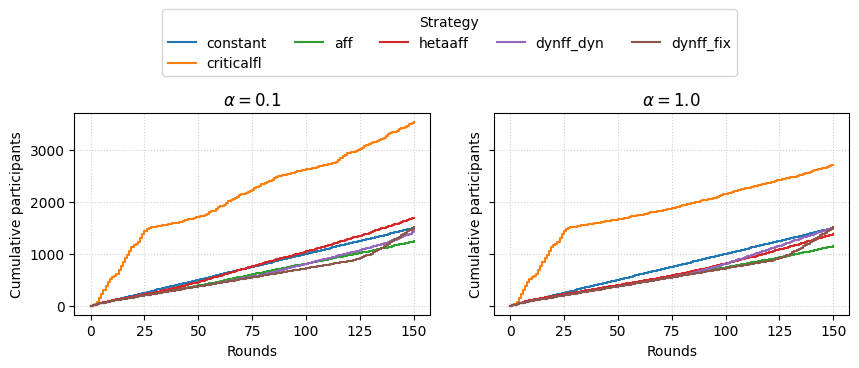

In [172]:

fig, axes = plot_cumulative_participants_by_round(
    {
        "constant":  num_participants_by_round_constant,
        "criticalfl":num_participants_by_round_critical,
        "aff":       num_participants_by_round_aff,
        "hetaaff":   num_participants_by_round_hetaaff,
        "dynff_dyn": num_participants_by_round_dynff_dyn,
        "dynff_fix": num_participants_by_round_dynff_fix,  # alpha -> {strategy -> {round: valor}}
    },
    x_order=[0.1, 1.0],
    title=None,
)

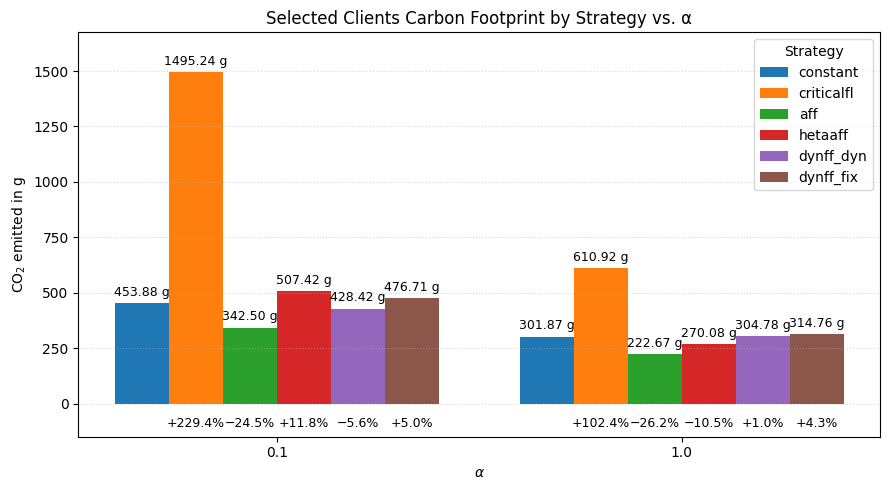

In [175]:
plot_carbon_grouped_with_labels({
    'constant': selected_ceq_constant,
    'criticalfl': selected_ceq_critical,    
    'aff': selected_ceq_aff,
    'hetaaff': selected_ceq_hetaaff,
    'dynff_dyn': selected_ceq_dynff_dyn,
    'dynff_fix': selected_ceq_dynff_fix,
}, x_order=[0.1, 1.0], title="Selected Clients Carbon Footprint by Strategy vs. α")

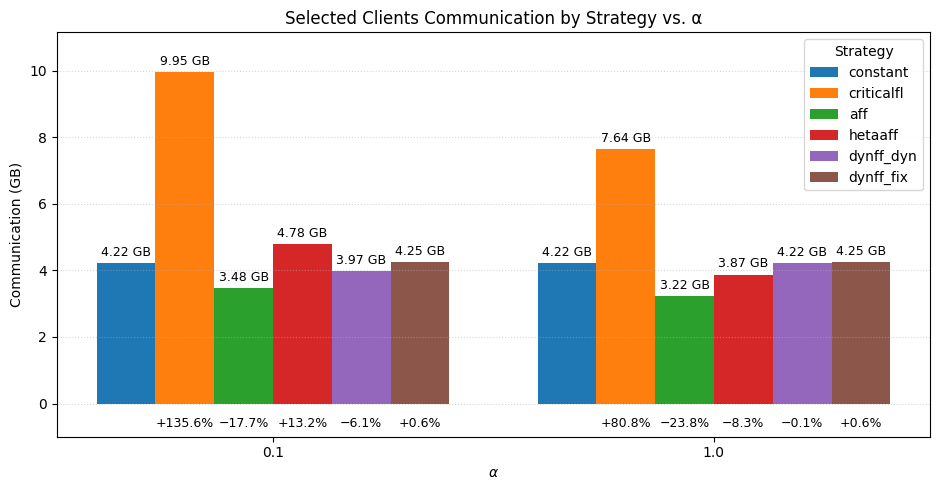

In [176]:
fig, ax = plot_communication_grouped_from_dfs(
    {
        'constant': dfb_mean_constant,
        'criticalfl': dfb_mean_critical,
        'aff': dfb_mean_aff,
        'hetaaff': dfb_mean_hetaaff,
        'dynff_dyn': dfb_mean_dynff_dyn,
        'dynff_fix': dfb_mean_dynff_fix,
    },
    x_order=[0.1, 1.0],
    title="Selected Clients Communication by Strategy vs. α",
)

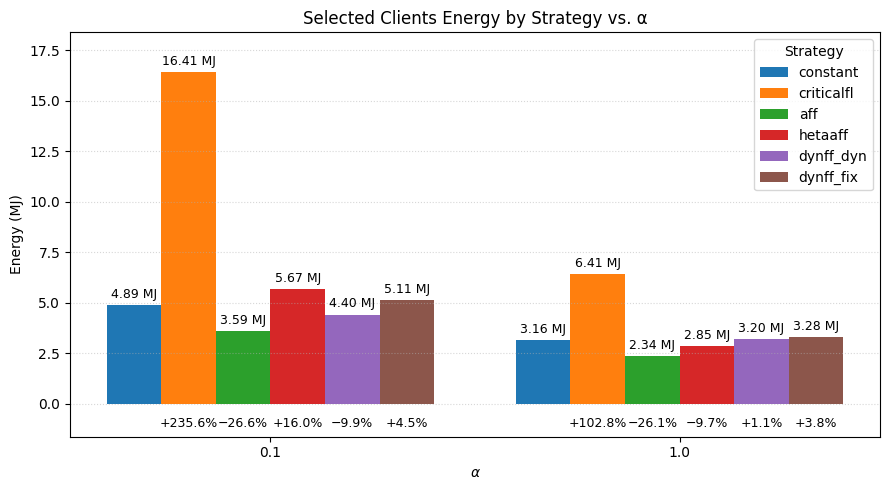

In [177]:
plot_energy_grouped_with_labels({
    'constant': selected_energy_constant,
    'criticalfl': selected_energy_critical,
    'aff': selected_energy_aff,
    'hetaaff': selected_energy_hetaaff,
    'dynff_dyn': selected_energy_dynff_dyn,
    'dynff_fix': selected_energy_dynff_fix,
}, x_order=[0.1, 1.0], title="Selected Clients Energy by Strategy vs. α")

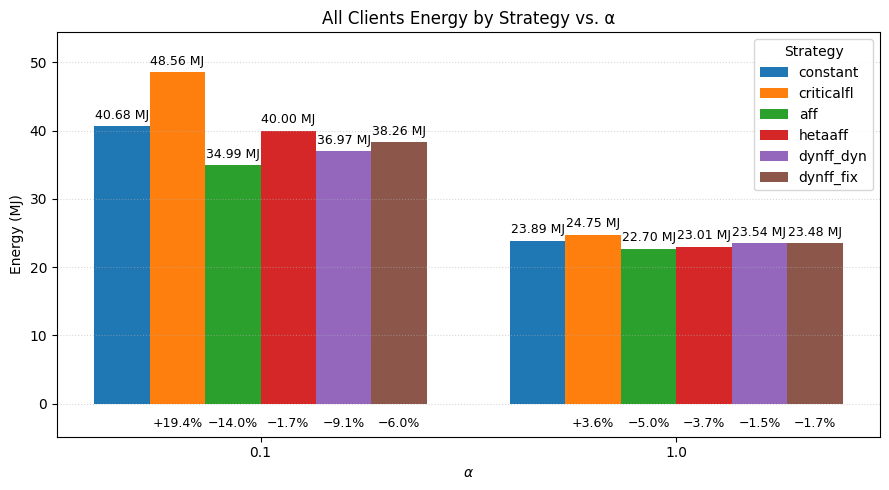

In [178]:
plot_energy_grouped_with_labels({
    'constant': totals_energy_constant,
    'criticalfl': totals_energy_critical,
    'aff': totals_energy_aff,
    'hetaaff': totals_energy_hetaaff,
    'dynff_dyn': totals_energy_dynff_dyn,
    'dynff_fix': totals_energy_dynff_fix,
}, x_order=[0.1, 1.0], title="All Clients Energy by Strategy vs. α")

/tmp/ipykernel_111215/1908991985.py:531: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.88])


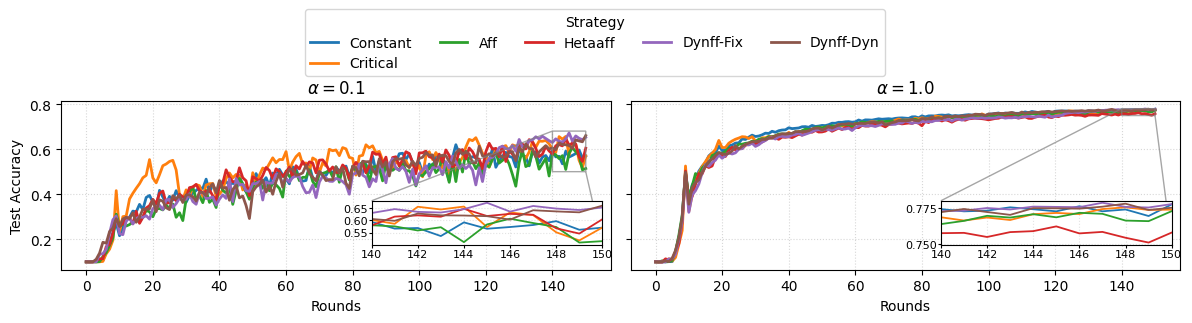

In [179]:
plot_accuracy_by_strategy({
    "Constant":  df_acc_rounds_mean_constant,
    "Critical":  df_acc_rounds_mean_critical,
    "Aff":       df_acc_rounds_mean_aff,
    "Hetaaff":   df_acc_rounds_mean_hetaaff,
    "Dynff-Fix":     df_acc_rounds_mean_dynff_fix,
    "Dynff-Dyn":     df_acc_rounds_mean_dynff_dyn,
})